<a href="https://colab.research.google.com/github/anjusree123/TensorFlow/blob/main/Finding_Best_Model_using_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Comparing Random Forest Support Vector Machine and Logistic Regression

import tensorflow as tf
import numpy as np
import keras
from keras.layers import Conv2D, Dense,Flatten,Dropout,MaxPooling2D, BatchNormalization
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
np.random.seed(42)

In [3]:
#loading mnist dataset
mnist=keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


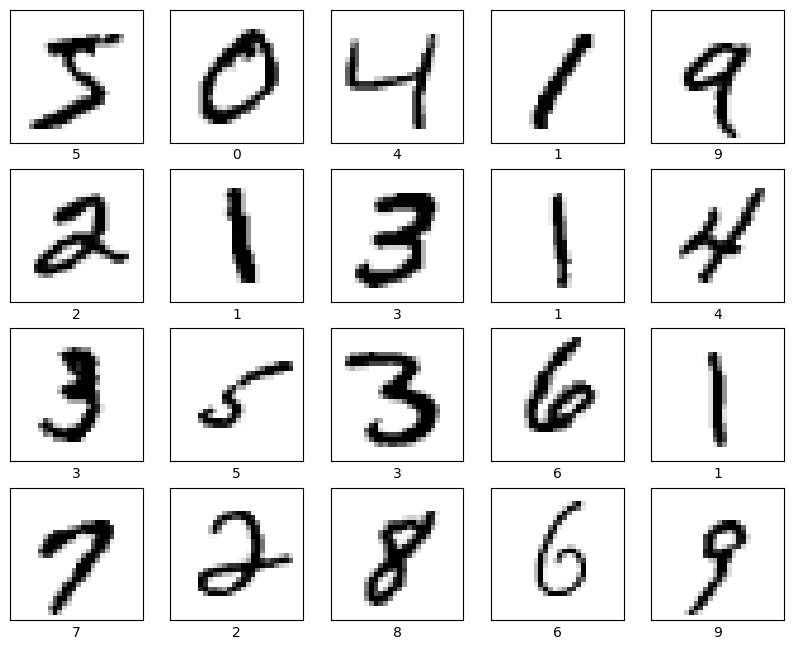

In [4]:
#plotting the figure
plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i],cmap=plt.cm.binary)
  plt.xlabel(y_train[i])


In [5]:
x_train,x_test=x_train/255.0,x_test/255.0
from sklearn.model_selection import train_test_split
x_grid,x_nouse,y_grid,y_nouse=train_test_split(x_train, y_train, test_size=0.9, random_state=42)
x_grid=np.expand_dims(x_grid,axis=3)

In [6]:
SIZE=x_grid.shape[1]

In [7]:
def feature_extractor():
  activation='sigmoid'
  feature=Sequential()
  feature.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 1)))
  feature.add(BatchNormalization())
    
  feature.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
  feature.add(BatchNormalization())
  feature.add(MaxPooling2D())
    
  feature.add(Flatten())
    
  return feature

In [8]:
feature_extractor=feature_extractor()
feature_extractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

In [9]:
X_for_RF=feature_extractor.predict(x_grid)

188/188 [==============================] - 9s 3ms/step


Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_grid) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(np.expand_dims(x_test, axis=3))

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

313/313 [==============================] - 0s 1ms/step
Accuracy =  0.9393


<Axes: >

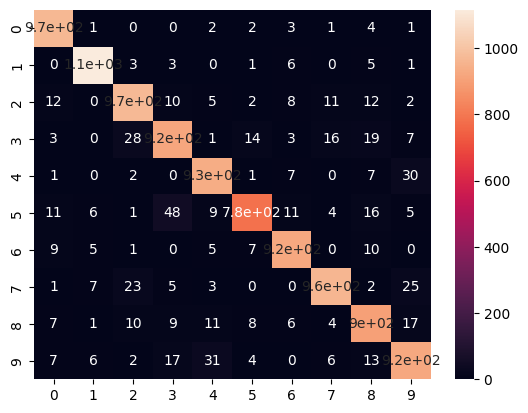

In [11]:
#Confusion Matrix - verify accuracy of each class
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [12]:
#Using Grid Search for the best model
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1],  #Regularization parameter. Providing only two as SVM is slow
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [10,20,30]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1]  #Regularization. . Providing only two as LR can be slow
        }
    }
}




In [13]:
print(model_params)

{'svm': {'model': SVC(gamma='auto'), 'params': {'C': [1], 'kernel': ['rbf', 'linear']}}, 'random_forest': {'model': RandomForestClassifier(), 'params': {'n_estimators': [10, 20, 30]}}, 'logistic_regression': {'model': LogisticRegression(solver='liblinear'), 'params': {'C': [1]}}}


In [14]:

scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=5, n_jobs=3, 
                         return_train_score=False)
    
    grid.fit(X_for_RF, y_grid)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

import pandas as pd    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)

                 model  best_score                   best_params
0                  svm    0.919667  {'C': 1, 'kernel': 'linear'}
1        random_forest    0.930667          {'n_estimators': 30}
2  logistic_regression    0.878500                      {'C': 1}
